## This notebook contains cells with code to generate dataset, train on CNN architecure, test and plot results: accuracy versus SNR and confusion matrix.

### This code is inspired by and reuses part of the code from [RADIOML](https://github.com/radioML/dataset), [DeepSig](https://www.deepsig.ai/datasets)


Artifacts block diagram <img src="ArtifactsBlocks.png" width=600 height=600 />
Dataset simulation block diagram. Note that RML22 dataset follows the block diagram in the sequence presented for simulation.
<br>
<br>Generates a dataset RML22 with all artifacts:<br>  $y_{RML22}[n] = e^{j2\pi f_{\rm err}nT_{s} + \theta_{\rm err}}\sum_{l}h[l]s[n\!-\!l\!-\!\zeta_{\rm err}] + z[n]$.<br>
<br>Datasets with specific artifacts such as clean data (mapped symbols that are pulse shaped), clean data with AWGN, clean data with clock effects only, clean data that undergoes fading can be generated following the equation:<br>
$y_{clean}[n] = s[n]$,<br>
$y_{AWGN}[n] = s[n] + z[n]$,<br>
$y_{clock}[n] = e^{j2\pi f_{\rm err}nT_{s} + \theta_{\rm err}}s[n]$,<br>
$y_{fading}[n] = \sum_{l}h[l]s[n-l]$,<br>

## Dataset generation.

In [17]:

import sys
from transmitters import transmitters
from source_alphabet import source_alphabet
from clockArtifacts import *
# import analyze_stats
from gnuradio import channels, gr, blocks, analog
import numpy as np
# import numpy.fft, gzip
import random
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import time
from itertools import product
import pickle
import datetime
import math


######### INPUT PARAMETERS #####################

## General signal parameters
f_c = 1e9 # Center frequency
clockrate = 100e6 # assuming usage of USRP N310, assuming a ADC and DAC clock rate equal to max analog bandwidth.
audio_rate = 44.1e3
samples_per_symbol = 2 #Upsampling factor
Tsym_LTE = 66.67e-6# Tsym for LTE is 66.67 microseconds.
# Samp_rate caluclated as = 8/71.3 (8 is the upsampling factor - i.e. Number of samples per symbol)
samp_rate = samples_per_symbol/Tsym_LTE#112.2e3
Ts = 1 / samp_rate  # sample interval

# Modulation parameters
excess_bandwidth = 0.35
modulation_index_CPFSK = 0.5
bandwidth_time_product = 0.3 # source for BT value chosen: https://comblock.com/download/com1028.pdf
sensitivity_GFSK = 1.57 # approx to pi/2.
output_stream_rate_WBFM = math.ceil(samp_rate/audio_rate)*audio_rate
max_freq_dev_WBFM = 75e3 # wideband FM freq deviation typical value - chosen from https://en.wikipedia.org/wiki/Frequency_modulation
tau=75e-6 # preemphasis time constant (default 75e-6), value used frorm https://github.com/gnuradio/gnuradio/blob/master/gr-analog/python/analog/wfm_tx.py


# Dataset simulation parameters
dataset = {}
numFrames_permodsnr = 2000
# print("numFrames_permodsnr: ",numFrames_permodsnr)
frame_length = 128  # length of a frame.
transients = 1000  # typically after channel, clock effects are applied, the output has trasients for
# the first 500 odd samples that need to be ignored.
# In a long array fo samples post effects such as clock,AWGN,fading etc., we iteratively carve chunks of samples equal to frame_length.
# and jump by an increment that is decided by the samples_incrementscale.
samples_incrementscale = 0.05
# The audio source file has almost no signal for the first few seconds.
analog_transients = int(audio_rate * 5)
# Samples of digitalsample_len will be passed through modulation, AWGN, ClockEffects, Fading blocks.
# A single frame will be carved out with a randomly placed window,
# with a minimum offset of transients out of signal of length digitalsample_len.
num_IF_perstream = 50 # A stream of this many frames are created and IFs carved out. Therefore the lower this value is, more likely the IFs will be more indepenedent of each other, since for each stream a separate instantiation of artifacts are initiated.
digitalsample_len = frame_length * num_IF_perstream + transients


""""
# Possible datasets that can be generated are: 'clean','AWGNOnly','ClockOnly','FadingOnly',’All'
clean - only the modulated signal with pulse shaping whereever applicable
AWGNOnly - Apply additive thermal noise applied to clean modulated signal for specified SNR levels, to the modulated signal.
Clock Only - Apply errors due to clock drifts - center frequency offset (CFO) and sample rate offset (SRO) and phase offset to the modulated signal.
FadingOnly - Apply fading effects only to the modulation signals.
All - All effects in the order of SRO->Fading->CFO->Phase offset-> AWGN
"""
datasettype_list = ['All'] 




## Signal artifact parameters

#AWGN
snr_levels = range(-20, 21, 2)
print("snr_levels: ",snr_levels)
#Fading
# delays in nanoseconds converted into fractional sample delays. Ech sample delay Ts = 9 micro seconds approx.
delays = [val_temp * (1e-9) * samp_rate for val_temp in [0, 50, 120, 200, 230, 500, 1600, 2300, 5000]]
mags_dB = [-1, -1, -1, 0, 0, 0, -3, -5, -7]
mags = [10 ** (mags_val / 20.0) for mags_val in mags_dB]
fD = 70  # ETU70, max doppler ferquency/frequency devaition - 70Hz.
ntaps = 8
numSinusoids = 8
LOS = False  # Rayleigh channel, no LOS component
Kfactor = 4

## Clock effects
clockeffects_dict = {}
clockeffects_dict['XOFreq'] = 10e6
clockeffects_dict['XO_standardDeviation'] = 1e-4
clockeffects_dict['XO_maxdeviation'] = 5
clockeffects_dict['LOScalingFactor'] = f_c/clockeffects_dict['XOFreq']
clockeffects_dict['TimetickScalingFactor'] = clockrate/clockeffects_dict['XOFreq']
clockeffects_dict['CFO_standardDeviation'] = clockeffects_dict['XO_standardDeviation']*clockeffects_dict['LOScalingFactor']
clockeffects_dict['SRO_standardDeviation'] = clockeffects_dict['XO_standardDeviation']*clockeffects_dict['TimetickScalingFactor']
clockeffects_dict['CFO_maxdeviation'] = clockeffects_dict['XO_maxdeviation']*clockeffects_dict['LOScalingFactor']
clockeffects_dict['SRO_maxdeviation'] = clockeffects_dict['XO_maxdeviation']*clockeffects_dict['TimetickScalingFactor']


# Analog data is large and takes time to read. Therefore done once in the beginning and random windows
# used to extract samples for each input frame.
# NOTE: If there are issues loading the large audio file such as RAM being filled up,
# you can use any smaller sized audio file.

print("Loading analog samples as an one time operation. Please be patient.")
tb = gr.top_block()
src_cont = source_alphabet("continuous")
snk_cont = blocks.vector_sink_f()
tb.connect(src_cont, snk_cont)
tb.run()

analogdata = np.array(snk_cont.data(), dtype=np.complex64)
len_analogdata = analogdata.shape[0]
print("Finished loading analog samples.")

seed = 1680000 # This seed is set to be consistent with seed used for dataset generation in the paper.

print("changed datasettype_list to all")
for datasettype in datasettype_list:
    print("Datasettype is :", datasettype)
    for modulation_flavour in list(transmitters.keys()):
        for modulation_type, snr in product(list(transmitters[modulation_flavour]), snr_levels):
            dataset[(modulation_type.modname, snr)] = np.zeros([numFrames_permodsnr, 2, frame_length], dtype=np.float32)
            ct = datetime.datetime.now()
            print("Generating data for Modulation type: ", modulation_type.modname," and snr: ", snr, " at time ", ct)
            frame_idx = 0
            noise_amp = 10 ** (-snr / 20.0)  # you need to divide by 20 instead of 10 to get the correct SNR.
            while frame_idx < numFrames_permodsnr:
                # print(modulation_flavour,modulation_type,snr,frame_idx)

                np.random.seed(seed)  # setting the random seed
                # To check if the seed has been set, use the command np.random.get_state()[1][0]

                if modulation_type.modname == 'GFSK':
                    mod = modulation_type(samples_per_symbol,sensitivity_GFSK,bandwidth_time_product)
                elif modulation_type.modname == 'CPFSK':
                    mod = modulation_type(modulation_index_CPFSK,samples_per_symbol)
                elif modulation_type.modname == 'WBFM':
                    mod = modulation_type(audio_rate, output_stream_rate_WBFM, tau,max_freq_dev_WBFM)
                elif (modulation_type.modname == 'AM-DSB') or (modulation_type == 'AM-SSB'):
                    mod = modulation_type(audio_rate, samp_rate)
                else:
                    mod = modulation_type(samples_per_symbol, excess_bandwidth)  # in the modified transmitter file, change
                add_block = blocks.add_vcc(1)
                noise_block = analog.noise_source_c(analog.GR_GAUSSIAN, noise_amp, seed)

                snk = blocks.vector_sink_c()
                fading_block = channels.selective_fading_model(numSinusoids, fD / samp_rate, LOS, Kfactor, \
                                                               seed, delays, mags, ntaps)
                tb = gr.top_block()

                if modulation_flavour == "discrete":
                    np.random.seed(seed)
                    src = source_alphabet("discrete", digitalsample_len, seed)
                elif modulation_flavour == "continuous":
                    # the first 5 seconds and last 60 seconds of the audio recording is ignored. The idx is the staring
                    # point for carving a sample stream for continuous type modulation.
                    np.random.seed(seed)
                    idx_analogdata = np.random.randint(analog_transients, len_analogdata - int(audio_rate * 60))
                    # For analog source, we simply are using the real part of the audio signal.
                    # This is also consistent with the implementation by Oshea who also uses only the real part,when using
                    # a complextofloat block.
                    analogdata_sample = np.real(analogdata[idx_analogdata:idx_analogdata + digitalsample_len])
                    src = blocks.vector_source_f(analogdata_sample, False, 1, [])
                    # Bock signature:  gnuradio.blocks.vector_source_f(data, repeat = False, vlen = 1, tags)


                ## XO value generation. This value will be passed onto SRO and CFO blocks where this will be scaled.
                ferr_bias_XO = np.random.uniform(-clockeffects_dict['XO_maxdeviation'] + clockeffects_dict['XO_standardDeviation'],\
                                                 clockeffects_dict['XO_maxdeviation'] - clockeffects_dict['XO_standardDeviation'])
                # digitalsample_len is the length of input source. This is modulated and upsampled. Therefore the XO value length that is applied to the modulated upsampled symbols should be of appropriate length of the upsampled modulated samples.
                XO_val_len = digitalsample_len*samples_per_symbol+10
                XO_val = np.zeros((XO_val_len,))
                XO_val[0] = clockeffects_dict['XO_standardDeviation'] * np.random.randn(1, ) + ferr_bias_XO
                # Check to ensure that CFO is contained within maximum deviation.
                while (XO_val[0] > clockeffects_dict['XO_maxdeviation']) or (XO_val[0] < -clockeffects_dict['XO_maxdeviation']):
                    XO_val[0] = clockeffects_dict['XO_standardDeviation'] * np.random.randn(1, ) + ferr_bias_XO

                for i in range(1, XO_val_len):
                    XO_val[i] = clockeffects_dict['XO_standardDeviation'] * np.random.randn(1, ) + XO_val[i - 1]
                    # Check to ensure that CFO is contained within maximum deviation.
                    while (XO_val[i] > clockeffects_dict['XO_maxdeviation']) or (XO_val[i] < -clockeffects_dict['XO_maxdeviation']):
                        XO_val[i] = clockeffects_dict['XO_standardDeviation'] * np.random.randn(1, ) + XO_val[i - 1]


                if datasettype == 'clean':
                    tb.connect(src, mod, snk)
                    tb.run()
                    samples = np.array(snk.data(), dtype=np.complex64)
                elif datasettype == 'AWGNOnly':
                    tb.connect(src, mod)
                    tb.connect(noise_block, (add_block, 1))
                    tb.connect(mod, (add_block, 0))
                    tb.connect(add_block, snk)
                    tb.run()
                    samples = np.array(snk.data(), dtype=np.complex64)
                elif datasettype == 'ClockOnly':
                    # Apply SRO followed by CFO followed by phase offset
                    tb.connect(src, mod, snk)
                    tb.run()
                    samples_mod = np.array(snk.data(), dtype=np.complex64)
                    samples_SRO = SROArtifact(samples_mod, XO_val, clockeffects_dict, samp_rate)
                    samples_SRO_CFO = CFOArtifact(samples_SRO, XO_val, clockeffects_dict, samp_rate)
                    samples_allClockArtifacts = phaseOffset(samples_SRO_CFO, seed)
                    samples = samples_allClockArtifacts
                elif datasettype == 'FadingOnly':
                    # Apply fading only
                    tb.connect(src, mod, fading_block, snk)
                    tb.run()
                    samples = np.array(snk.data(), dtype=np.complex64)
                elif datasettype == 'All':
                    tb.connect(src, mod, snk)
                    tb.run()
                    samples_clean = np.array(snk.data(), dtype=np.complex64)
                    samples_SRO = SROArtifact(samples_clean, XO_val, clockeffects_dict, samp_rate)
                    samples_SRO_src_block = blocks.vector_source_c(samples_SRO, False, 1, [])
                    snk2 = blocks.vector_sink_c()
                    tb.connect(samples_SRO_src_block, fading_block, snk2)
                    tb.run()
                    samples_SRO_Fading = np.array(snk2.data(), dtype=np.complex64)
                    samples_SRO_Fading_CFO = CFOArtifact(samples_SRO_Fading, XO_val, clockeffects_dict, samp_rate)
                    samples_SRO_Fading_CFO_Phaseoffset = phaseOffset(samples_SRO_Fading_CFO, seed)

                    samples_SRO_Fading_CFO_Phaseoffset_block = blocks.vector_source_c(samples_SRO_Fading_CFO_Phaseoffset, False, 1, [])
                    # tb.connect(src, mod)
                    snk3 = blocks.vector_sink_c()
                    tb.connect(noise_block, (add_block, 1))
                    tb.connect(samples_SRO_Fading_CFO_Phaseoffset_block, (add_block, 0))
                    tb.connect(add_block, snk3)
                    tb.run()
                    samples_alleffects = np.array(snk3.data(), dtype=np.complex64)
                    samples = samples_alleffects

                # remove transients from the samples post fading.
                samples = samples[transients:]
                len_sampAlleffects = samples.shape[0]

                np.random.seed(seed)
                incr_idx = np.random.randint(0,int(len_sampAlleffects*samples_incrementscale))
                start_idx = 0
                start_idx = start_idx + incr_idx
                #frame_idx = frame_idx + 1
                while (start_idx +frame_length < len_sampAlleffects) and (frame_idx < numFrames_permodsnr):
                    frame_allEffects = samples[start_idx:start_idx+frame_length]
                    
                    #Normalizing frame to have unit energy
                    energy = np.sum((np.abs(frame_allEffects)))
                    frame_allEffects = frame_allEffects / energy
                    
                    dataset[(modulation_type.modname, snr)][frame_idx, 0, :] = np.real(frame_allEffects)
                    dataset[(modulation_type.modname, snr)][frame_idx, 1, :] = np.imag(frame_allEffects)
                    seed = seed + 1
                    np.random.seed(seed)
                    incr_idx = np.random.randint(0,int(len_sampAlleffects*samples_incrementscale))
                    start_idx = start_idx + incr_idx + frame_length
                    #print(start_idx,frame_idx)
                    frame_idx = frame_idx + 1


    filelocation = ""
    savefilename = filelocation + "RML22"
    outfile1 = open(savefilename, 'wb')
    pickle.dump(dataset, outfile1)
    outfile1.close()
    # ct stores current time
    ct = datetime.datetime.now()
    print(ct)


numFrames_permodsnr:  2000
snr_levels:  range(-20, 21, 2)
Loading analog samples as an one time operation. Please be patient.
Finished loading analog samples.
changed datasettype_list to all
Datasettype is : All
Generating data for Modulation type:  BPSK  and snr:  -20  at time  2022-02-08 19:07:29.897620
Generating data for Modulation type:  BPSK  and snr:  -18  at time  2022-02-08 19:07:45.570304
Generating data for Modulation type:  BPSK  and snr:  -16  at time  2022-02-08 19:08:01.081447
Generating data for Modulation type:  BPSK  and snr:  -14  at time  2022-02-08 19:08:16.976917
Generating data for Modulation type:  BPSK  and snr:  -12  at time  2022-02-08 19:08:32.861930
Generating data for Modulation type:  BPSK  and snr:  -10  at time  2022-02-08 19:08:48.931910
Generating data for Modulation type:  BPSK  and snr:  -8  at time  2022-02-08 19:09:04.358462
Generating data for Modulation type:  BPSK  and snr:  -6  at time  2022-02-08 19:09:20.012251
Generating data for Modulation

Generating data for Modulation type:  QAM16  and snr:  -18  at time  2022-02-08 19:30:09.425212
Generating data for Modulation type:  QAM16  and snr:  -16  at time  2022-02-08 19:30:30.111618
Generating data for Modulation type:  QAM16  and snr:  -14  at time  2022-02-08 19:30:50.784033
Generating data for Modulation type:  QAM16  and snr:  -12  at time  2022-02-08 19:31:11.499271
Generating data for Modulation type:  QAM16  and snr:  -10  at time  2022-02-08 19:31:32.835436
Generating data for Modulation type:  QAM16  and snr:  -8  at time  2022-02-08 19:31:52.943860
Generating data for Modulation type:  QAM16  and snr:  -6  at time  2022-02-08 19:32:13.682211
Generating data for Modulation type:  QAM16  and snr:  -4  at time  2022-02-08 19:32:34.323884
Generating data for Modulation type:  QAM16  and snr:  -2  at time  2022-02-08 19:32:54.690914
Generating data for Modulation type:  QAM16  and snr:  0  at time  2022-02-08 19:33:15.512752
Generating data for Modulation type:  QAM16  a

Generating data for Modulation type:  WBFM  and snr:  -12  at time  2022-02-08 19:59:31.548698
Generating data for Modulation type:  WBFM  and snr:  -10  at time  2022-02-08 19:59:46.893792
Generating data for Modulation type:  WBFM  and snr:  -8  at time  2022-02-08 20:00:02.087878
Generating data for Modulation type:  WBFM  and snr:  -6  at time  2022-02-08 20:00:17.358488
Generating data for Modulation type:  WBFM  and snr:  -4  at time  2022-02-08 20:00:31.940935
Generating data for Modulation type:  WBFM  and snr:  -2  at time  2022-02-08 20:00:46.686617
Generating data for Modulation type:  WBFM  and snr:  0  at time  2022-02-08 20:01:01.949794
Generating data for Modulation type:  WBFM  and snr:  2  at time  2022-02-08 20:01:17.495796
Generating data for Modulation type:  WBFM  and snr:  4  at time  2022-02-08 20:01:32.740180
Generating data for Modulation type:  WBFM  and snr:  6  at time  2022-02-08 20:01:47.597553
Generating data for Modulation type:  WBFM  and snr:  8  at ti

## Train dataset

Dataset loading completed
Starting training
Epoch: 1 LR: [0.001]
Epoch number:  1  starting
2022-02-08 20:10:13.296238
Epoch Number:  1  and Batch number:  1000  complete
2022-02-08 20:10:23.427911
Epoch Number:  1  and Batch number:  2000  complete
2022-02-08 20:10:33.501409
Epoch Number:  1  and Batch number:  3000  complete
2022-02-08 20:10:43.260338
Epoch Number:  1  and Batch number:  4000  complete
2022-02-08 20:10:53.226721
Epoch Number:  1  and Batch number:  5000  complete
2022-02-08 20:11:02.878513
Epoch Number:  1  and Batch number:  6000  complete
2022-02-08 20:11:12.348883
Epoch Number:  1  and Batch number:  7000  complete
2022-02-08 20:11:22.112006
Epoch Number:  1  and Batch number:  8000  complete
2022-02-08 20:11:32.330722
Train accuracy:  0.47648065476190476
Validation accuracy:  0.4715922619047619
Previous best and current validation losses are:  inf 1.323435214432803
Epoch 1 : Training Loss = 1.312514,  Validation Loss = 1.323435
Epoch: 2 LR: [0.001]
Epoch number: 

Epoch Number:  10  and Batch number:  1000  complete
2022-02-08 20:22:59.148312
Epoch Number:  10  and Batch number:  2000  complete
2022-02-08 20:23:08.926855
Epoch Number:  10  and Batch number:  3000  complete
2022-02-08 20:23:17.980258
Epoch Number:  10  and Batch number:  4000  complete
2022-02-08 20:23:27.590261
Epoch Number:  10  and Batch number:  5000  complete
2022-02-08 20:23:37.083033
Epoch Number:  10  and Batch number:  6000  complete
2022-02-08 20:23:47.122757
Epoch Number:  10  and Batch number:  7000  complete
2022-02-08 20:23:56.852871
Epoch Number:  10  and Batch number:  8000  complete
2022-02-08 20:24:06.558075
Train accuracy:  0.6071279761904762
Validation accuracy:  0.5950744047619048
Previous best and current validation losses are:  0.9886319872104761 0.9855347031896765
Epoch 10 : Training Loss = 0.953276,  Validation Loss = 0.985535
Epoch: 11 LR: [0.0001]
Epoch number:  11  starting
2022-02-08 20:24:12.665086
Epoch Number:  11  and Batch number:  1000  complete

Epoch Number:  19  and Batch number:  1000  complete
2022-02-08 20:35:28.770496
Epoch Number:  19  and Batch number:  2000  complete
2022-02-08 20:35:38.304236
Epoch Number:  19  and Batch number:  3000  complete
2022-02-08 20:35:47.912062
Epoch Number:  19  and Batch number:  4000  complete
2022-02-08 20:35:56.868435
Epoch Number:  19  and Batch number:  5000  complete
2022-02-08 20:36:06.527971
Epoch Number:  19  and Batch number:  6000  complete
2022-02-08 20:36:16.557108
Epoch Number:  19  and Batch number:  7000  complete
2022-02-08 20:36:26.432173
Epoch Number:  19  and Batch number:  8000  complete
2022-02-08 20:36:36.928757
Train accuracy:  0.6149553571428571
Validation accuracy:  0.6004017857142857
Previous best and current validation losses are:  0.9777431479006102 0.9775352161942106
Epoch 19 : Training Loss = 0.940498,  Validation Loss = 0.977535
Epoch: 20 LR: [1e-05]
Epoch number:  20  starting
2022-02-08 20:36:42.749855
Epoch Number:  20  and Batch number:  1000  complete


Epoch Number:  28  and Batch number:  1000  complete
2022-02-08 20:48:10.007336
Epoch Number:  28  and Batch number:  2000  complete
2022-02-08 20:48:19.315313
Epoch Number:  28  and Batch number:  3000  complete
2022-02-08 20:48:28.611406
Epoch Number:  28  and Batch number:  4000  complete
2022-02-08 20:48:38.633395
Epoch Number:  28  and Batch number:  5000  complete
2022-02-08 20:48:48.864489
Epoch Number:  28  and Batch number:  6000  complete
2022-02-08 20:48:58.397174
Epoch Number:  28  and Batch number:  7000  complete
2022-02-08 20:49:08.420468
Epoch Number:  28  and Batch number:  8000  complete
2022-02-08 20:49:17.964640
Train accuracy:  0.6149851190476191
Validation accuracy:  0.6009077380952381
Validation loss increased from 0.976262 to 0.977598.
Epoch 28 : Training Loss = 0.939910,  Validation Loss = 0.977598
Epoch: 29 LR: [1.0000000000000002e-06]
Epoch number:  29  starting
2022-02-08 20:49:23.827592
Epoch Number:  29  and Batch number:  1000  complete
2022-02-08 20:49:3

Epoch Number:  37  and Batch number:  1000  complete
2022-02-08 21:00:41.770379
Epoch Number:  37  and Batch number:  2000  complete
2022-02-08 21:00:51.822387
Epoch Number:  37  and Batch number:  3000  complete
2022-02-08 21:01:01.624756
Epoch Number:  37  and Batch number:  4000  complete
2022-02-08 21:01:10.982345
Epoch Number:  37  and Batch number:  5000  complete
2022-02-08 21:01:20.544335
Epoch Number:  37  and Batch number:  6000  complete
2022-02-08 21:01:30.246240
Epoch Number:  37  and Batch number:  7000  complete
2022-02-08 21:01:40.231869
Epoch Number:  37  and Batch number:  8000  complete
2022-02-08 21:01:50.207835
Train accuracy:  0.6164136904761904
Validation accuracy:  0.601875
Validation loss increased from 0.976262 to 0.976307.
Epoch 37 : Training Loss = 0.938149,  Validation Loss = 0.976307
Epoch: 38 LR: [1.0000000000000002e-07]
Epoch number:  38  starting
2022-02-08 21:01:55.732721
Epoch Number:  38  and Batch number:  1000  complete
2022-02-08 21:02:05.398121
E

Epoch Number:  46  and Batch number:  1000  complete
2022-02-08 21:13:16.871002
Epoch Number:  46  and Batch number:  2000  complete
2022-02-08 21:13:26.384572
Epoch Number:  46  and Batch number:  3000  complete
2022-02-08 21:13:35.998670
Epoch Number:  46  and Batch number:  4000  complete
2022-02-08 21:13:45.768601
Epoch Number:  46  and Batch number:  5000  complete
2022-02-08 21:13:55.164472
Epoch Number:  46  and Batch number:  6000  complete
2022-02-08 21:14:05.229393
Epoch Number:  46  and Batch number:  7000  complete
2022-02-08 21:14:14.828897
Epoch Number:  46  and Batch number:  8000  complete
2022-02-08 21:14:24.812437
Train accuracy:  0.6157998511904762
Validation accuracy:  0.6023363095238096
Validation loss increased from 0.976112 to 0.978732.
Epoch 46 : Training Loss = 0.941195,  Validation Loss = 0.978732
Epoch: 47 LR: [1.0000000000000004e-08]
Epoch number:  47  starting
2022-02-08 21:14:30.656276
Epoch Number:  47  and Batch number:  1000  complete
2022-02-08 21:14:4

Epoch Number:  55  and Batch number:  1000  complete
2022-02-08 21:25:38.127674
Epoch Number:  55  and Batch number:  2000  complete
2022-02-08 21:25:47.664733
Epoch Number:  55  and Batch number:  3000  complete
2022-02-08 21:25:57.017458
Epoch Number:  55  and Batch number:  4000  complete
2022-02-08 21:26:06.534208
Epoch Number:  55  and Batch number:  5000  complete
2022-02-08 21:26:15.504353
Epoch Number:  55  and Batch number:  6000  complete
2022-02-08 21:26:25.082637
Epoch Number:  55  and Batch number:  7000  complete
2022-02-08 21:26:34.121349
Epoch Number:  55  and Batch number:  8000  complete
2022-02-08 21:26:43.645968
Train accuracy:  0.6161681547619048
Validation accuracy:  0.6018898809523809
Validation loss increased from 0.976112 to 0.977241.
Epoch 55 : Training Loss = 0.938929,  Validation Loss = 0.977241
Epoch: 56 LR: [1.0000000000000005e-09]
Epoch number:  56  starting
2022-02-08 21:26:49.273229
Epoch Number:  56  and Batch number:  1000  complete
2022-02-08 21:26:5

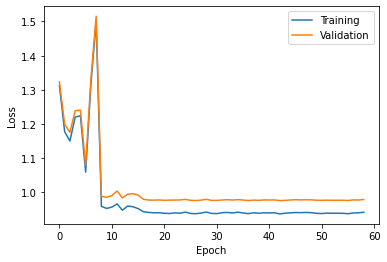

<Figure size 432x288 with 0 Axes>

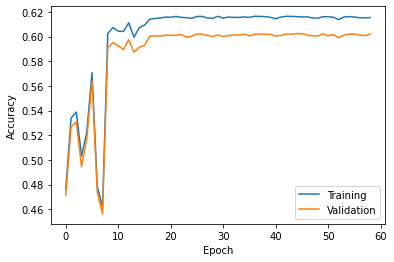

<Figure size 432x288 with 0 Axes>

In [18]:

import sys

import numpy as np
import pickle
import datetime
import torch.nn as nn
import torch
from TrainHelper import train_model
from sklearn.model_selection import train_test_split
from CNNArchitecture import CNNArchitecture
import os
import matplotlib.pyplot as plt
import logging

# Set GPUID in here
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

modulationTypes = ["BPSK", "QPSK", "8PSK", "16QAM", "64QAM", "PAM4", "GFSK", "CPFSK", "BFM", "DSBAM"]

label_dict = {'QAM16': 0, 'QAM64': 1, '8PSK': 2, 'WBFM': 3, 'BPSK': 4, 'CPFSK': 5, 'AM-DSB': 6, 'GFSK': 7,
              'PAM4': 8, 'QPSK': 9}

TrainParams = {}
DatasetParams = {}
L = 128
# Training done for the following batch sizes
BS_range = [32]
LR = 10 ** -3
initialize_type = 'Xavier'  # ['Xavier','Orthogonal']
TrainParams['num_epochs'] = 200
TrainParams['n_epochs_earlystop'] = 16
TrainParams['test_bactchsize'] = 1024
TrainParams['LRScheduler_stepsize'] = 8  # These many iterations are done for every step
TrainParams['LRSchedulerGamma'] = 0.1  # Every r itertaions, the LR is reduced by a multiplicative factor of LRSchedulerDecay
weight_decay = TrainParams['weight_decay'] = 5e-4
TrainParams['optimizer_type'] = 'Adam'
TrainParams['validation_size'] = 0.2
TrainParams['clip'] = 5

DatasetParams['SNRrange'] = np.arange(-20, 21, 2)
DatasetParams['Modulationtypes'] = ['QAM16', 'QAM64', '8PSK', 'WBFM', 'BPSK', 'CPFSK', 'AM-DSB', 'GFSK', 'PAM4', 'QPSK']
DatasetParams['NumClasses'] = len(DatasetParams['Modulationtypes'])
DatasetParams['datatype'] = 'RML22'
DatasetParams['NumFrames'] = 2000
TrainParams['criterion'] = nn.CrossEntropyLoss()
TrainParams['computing_device'] = torch.device("cuda")

Savemodelfile_location = ''
datafilelocation = ''
datafilename = datafilelocation + DatasetParams['datatype']

            
for BS in BS_range:
        TrainParams['initialize_type'] = initialize_type
        TrainParams['L'] = L
        TrainParams['BS'] = BS
        TrainParams['LR'] = LR

        Savemodelfilename = DatasetParams['datatype']

        '''
        Load dataset from the pickle file. The data is in a dictionary format with keys corresponding 
        to modulation and SNR. Every dict item in the dictionary contains X items per mod per SNR.
        '''
        f = open(datafilename, 'rb')
        dataset = pickle.load(f, encoding='latin1')
        f.close()
        print("Dataset loading completed")
        # read the keys - snrs and mods.
        snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset.keys())))), [1, 0])
        X = []
        lbl = []
        for mod in mods:
            if mod in DatasetParams['Modulationtypes']:
                for snr in snrs:
                    if snr in DatasetParams['SNRrange']:
                        X.append(dataset[(mod, snr)][0:DatasetParams['NumFrames']])
                        for i in range(DatasetParams['NumFrames']):  lbl.append((mod, snr))


        X = np.vstack(X)
        label_val = list(map(lambda x: lbl[x][0], range(len(lbl))))
        label = list(map(lambda x: label_dict[x], label_val))
        label = np.array(label)
        data = X[:, :, 0:L]
        del dataset, X  # deleting large arrays to free up space in RAM.
        modelclass = CNNArchitecture


        def loadSplitTrain(modelclass, Savemodelfile_location, Savemodelfilename, data, label, TrainParams):

            model = modelclass(DatasetParams['NumClasses'])
            x_train, x_test, y_train, y_test = train_test_split(data, label,
                                                                test_size=TrainParams['validation_size'] \
                                                                , random_state=1)
            x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                              test_size=TrainParams['validation_size'],
                                                              random_state=1)
            train_set = {'data': torch.tensor(x_train).float(), 'labels': torch.tensor(y_train).float()}
            val_set = {'data': torch.tensor(x_val).float(), 'labels': torch.tensor(y_val).float()}
            del data

            ############ ############### Train Model ########################## ##########
            ############ ############ ############ ############ ############ ############
            model_file = Savemodelfile_location + Savemodelfilename + '_model.pt'
            model1, Loss, Accuracy = train_model(model, model_file, train_set, val_set, TrainParams)
            # Save Loss and accuracy plots
        
            plt.figure(1)
            epochs = [i for i in range(len(Loss['train']))]
            plt.plot(epochs, Loss['train'])
            plt.plot(epochs, Loss['valid'])
            plt.title('')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend(['Training', 'Validation'])
            plt.savefig(Savemodelfile_location + Savemodelfilename + 'model_loss.png')
            plt.show()
            plt.clf()
            # plt.show()

            plt.figure(2)
            plt.plot(epochs, Accuracy['train'])
            plt.plot(epochs, Accuracy['valid'])
            plt.title('')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend(['Training', 'Validation'])
            plt.savefig(Savemodelfile_location + Savemodelfilename + 'model_acc.png')
            plt.show()
            plt.clf()


        loadSplitTrain(modelclass, Savemodelfile_location, Savemodelfilename, data, label, TrainParams)
f.close()

## Test and plot accuracy versus SNR

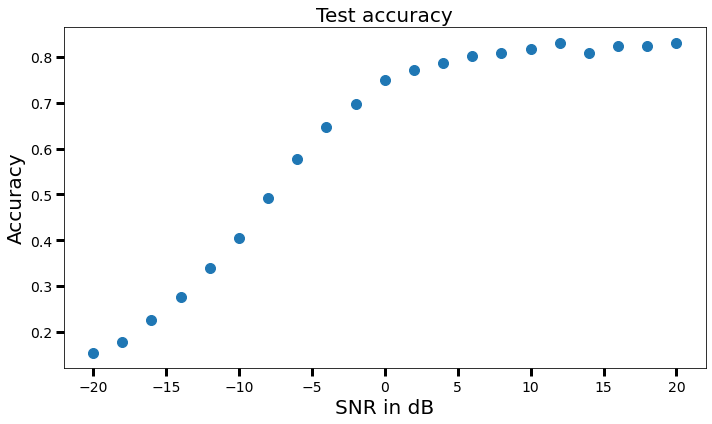

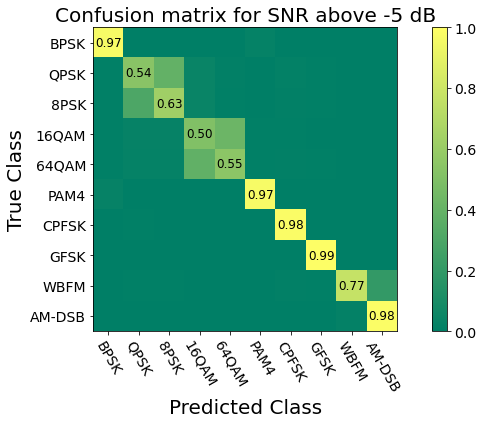

In [19]:

import sys

import numpy as np
import pickle
import datetime
import torch.nn as nn
import torch
from TrainHelper import train_model
from sklearn.model_selection import train_test_split
from CNNArchitecture import CNNArchitecture
import os
import matplotlib.pyplot as plt
import logging
from sklearn.metrics import confusion_matrix

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')
    
    
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

modulationTypes = ["BPSK", "QPSK", "8PSK", "16QAM", "64QAM", "PAM4", "GFSK", "CPFSK", "BFM", "DSBAM"]

label_dict = {'QAM16': 0, 'QAM64': 1, '8PSK': 2, 'WBFM': 3, 'BPSK': 4, 'CPFSK': 5, 'AM-DSB': 6, 'GFSK': 7,
              'PAM4': 8, 'QPSK': 9}

DatasetParams = {}
# L = 128
DatasetParams['SNRrange'] = np.arange(-20, 21, 2)
DatasetParams['Modulationtypes'] = ['QAM16', 'QAM64', '8PSK', 'WBFM', 'BPSK', 'CPFSK', 'AM-DSB', 'GFSK', 'PAM4', 'QPSK']
DatasetParams['NumClasses'] = len(DatasetParams['Modulationtypes'])
DatasetParams['datatype'] = 'RML22'
DatasetParams['NumFrames'] = 2000
DatasetParams['frameLength'] = 128
TestParams = {}
TestParams['validation_size'] = 0.2
TestParams['test_BS'] = 1024
TestParams['computing_device'] = torch.device("cuda")
modulation_reordered = ['BPSK', 'QPSK', '8PSK', '16QAM', '64QAM', 'PAM4', 'CPFSK', 'GFSK', 'WBFM', 'AM-DSB']
DatasetParams['NumClasses'] = len(DatasetParams['Modulationtypes'])

modelfile = DatasetParams['datatype']+ '_model.pt'
accuracy = {}
dataset = {}

def calculate_accuracy(model, data, label, batch_size, computing_device, CM_flag):
    model.eval()
    with torch.no_grad():
        n_samples = data.shape[0]
        n_minibatch = int((n_samples + batch_size - 1) / batch_size)
        accuracy = 0
        I = np.arange(n_samples)
        CM_prediction = []
        for i in range(n_minibatch):
            idx = I[batch_size * i:min(batch_size * (i + 1), n_samples)]
            dt = data[idx].to(computing_device)
            lbl = label[idx].numpy()
            output = model(dt)
            output = output.cpu().numpy()
            output = np.argmax(output, axis=1)
            CM_prediction.extend(list(output))
            accuracy += np.sum(output == lbl)
        if CM_flag:
            return accuracy / n_samples, CM_prediction
        else:
            return accuracy / n_samples

datafilename = DatasetParams['datatype'] 
f = open(datafilename, 'rb')
dataset = pickle.load(f, encoding='latin1')
f.close()

    

for mod in DatasetParams['Modulationtypes']:
    for snr in DatasetParams['SNRrange']:

        # Load pre-trained model
        modelclass = CNNArchitecture
        if 'model' in globals():
            del model  # deleting it so that pre-loaded model in previous loop iteration doesnt not mess up this one.
        model = modelclass(DatasetParams['NumClasses'])
        model.load_state_dict(torch.load(modelfile))
        model = model.to(TestParams['computing_device'])
        data = dataset[(mod, snr)][0:DatasetParams['NumFrames']]
        label = label_dict[mod]*np.ones((data.shape[0],))
        x_train, x_test, y_train, y_test = train_test_split(data, label,
                                                            test_size=TestParams['validation_size'],
                                                            random_state=1)
        test_data = torch.tensor(x_test).float()
        test_label = torch.tensor(y_test).float()
        accuracy[(mod,snr)] = calculate_accuracy(model, test_data, test_label,
                                                                            TestParams['test_BS'],
                                                                            TestParams['computing_device'],False)
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset.keys())))), [1, 0])
lowSNR = -4
highSNR = 21
snrrange_confusionmatrix = range(lowSNR,highSNR,2)
X = []
lbl = []
for mod in mods:
        for snr in snrrange_confusionmatrix:
                X.append(dataset[(mod, snr)][0:DatasetParams['NumFrames']])
                for i in range(DatasetParams['NumFrames']):  lbl.append((mod, snr))
del dataset
X = np.vstack(X)
label_val = list(map(lambda x: lbl[x][0], range(len(lbl))))
label = list(map(lambda x: label_dict[x], label_val))
label = np.array(label)
dataset = X[:, :, 0:DatasetParams['frameLength']]
del X
    
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=\
                        TestParams['validation_size'],random_state=1)
test_data = torch.tensor(x_test).float()
test_label = torch.tensor(y_test).float()
acc_dummy, y_pred = calculate_accuracy(model, test_data, test_label, TestParams['test_BS'],\
                        TestParams['computing_device'],True)
# Order of modulations are BPSK, QPSK, 8PSK, 16QAM, 64QAM, PAM4, CPFSK, GFSK, QBFM, AM-DSB
        # We group similar modulation types together in the confusion matrix plots. 
        # Phase senstive ones followed by other digital and then analog modulation types.
label_reordered = [4, 9, 2, 0, 1, 8, 5, 7, 3, 6]
confusion_mat = confusion_matrix(y_test, y_pred, label_reordered)
confusion_mat = confusion_mat.astype(float)        

accvsSNR = {}
plt.figure(1,figsize=(10,6))
snridx = 0
accvsSNR = np.zeros((len(DatasetParams['SNRrange']),))
for snr in DatasetParams['SNRrange']:
    for mod in DatasetParams['Modulationtypes']:
        accvsSNR[snridx] = accvsSNR[snridx] + accuracy[mod,snr]
    accvsSNR[snridx] = accvsSNR[snridx]/len(DatasetParams['Modulationtypes'])
    snridx = snridx+1
markerval = 'o'
plt.plot(DatasetParams['SNRrange'],accvsSNR,markerval,markersize=10)

plt.tick_params(top=False,bottom=True,left=True,right=False,labelleft=True,labelbottom=True,length=8,width=3,\
                direction='out')
# plt.legend(legend_text,fontsize=36)
plt.title("Test accuracy",fontsize=20)
plt.xlabel("SNR in dB",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

confusionmat_norm = np.zeros(confusion_mat.shape)
for row_idx in np.arange(confusion_mat.shape[0]):
    sum = np.sum(confusion_mat[row_idx])
    for col_idx in np.arange(confusion_mat.shape[1]):
        confusionmat_norm[row_idx][col_idx] = confusion_mat[row_idx][col_idx]/sum
plt.figure(1,figsize=(10,6))

im = plt.imshow(confusionmat_norm, cmap='summer', interpolation='nearest',vmin=0, vmax=1)

width, height = confusionmat_norm.shape
for x in range(width):
    for y in range(height):
        if x==y:

            confusionmat_norm_val_2decimalplaces = "{:0.2f}".format(confusionmat_norm[x][y])
            if confusionmat_norm_val_2decimalplaces == "1.00":
                confusionmat_norm_val_2decimalplaces = "1.0"
            if confusionmat_norm_val_2decimalplaces == "0.00":
                confusionmat_norm_val_2decimalplaces = "0"
            plt.annotate(str(confusionmat_norm_val_2decimalplaces), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=12)

plt.xticks(np.arange(DatasetParams['NumClasses']), modulation_reordered, rotation=300,fontsize=14)
plt.yticks([], [])
plt.title("Confusion matrix for SNR above -5 dB",fontsize=20)
plt.xlabel('Predicted Class',fontsize=20)
cbar = plt.colorbar(im)
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)
plt.yticks(np.arange(DatasetParams['NumClasses']), modulation_reordered, rotation=0,fontsize=14)
plt.ylabel('True Class',fontsize=20)
plt.tight_layout()
plt.show()

